In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import gc
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, laplace
from scipy.signal import filtfilt, resample
import torch
import deepwave
import cv2

from deepinvhessian.utilities import *
from deepinvhessian.filters import *
import deepinvhessian.fwi as fwi
from deepinvhessian.imaging import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
set_seed(14)

# https://stackoverflow.com/questions/48152674/how-do-i-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 1.9 GB
Cached:    2.4 GB


## Prepare data

In [16]:
# Velocity model
inputvolve = np.load('../data/Velocities.npz')
velback = inputvolve["vback"]
print(velback.shape)
x = inputvolve["x"]
z = inputvolve["z"]
r = inputvolve["recs"].T

(900, 1290)


In [17]:
velback_no_water = np.copy(velback)
velback_no_water[velback_no_water==1480] = 1800
model_init = gaussian_filter(velback_no_water, sigma=60)
model_init = cv2.resize(model_init, (516, 360))
model_init = torch.tensor(model_init)

Text(0, 0.5, 'z [m]')

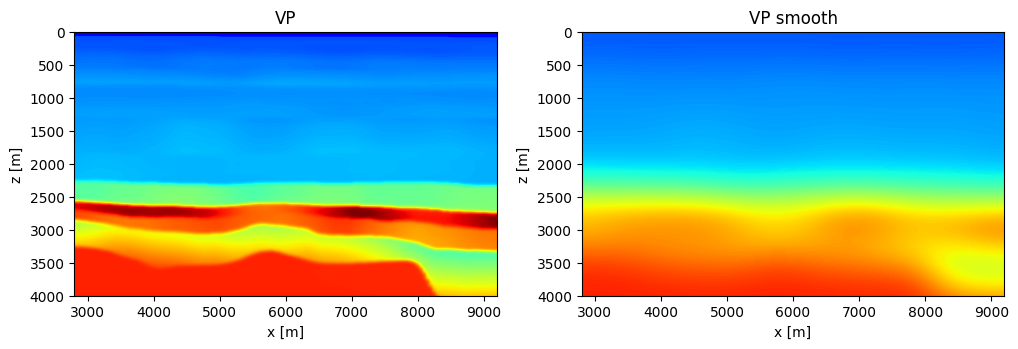

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(velback, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
axs[0].set_xlim(2800, 9200)
axs[0].set_ylim(4000, 0)
axs[0].set_title('VP')
axs[0].set_xlabel(r'x [m]')
axs[0].set_ylabel(r'z [m]')
axs[1].imshow(model_init, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
axs[1].set_xlim(2800, 9200)
axs[1].set_ylim(4000, 0)
axs[1].set_title('VP smooth')
axs[1].set_xlabel(r'x [m]')
axs[1].set_ylabel(r'z [m]')
# plt.savefig(f'final_results/model_init.png', bbox_inches='tight', dpi=300)

In [19]:
# MDD data
fmdd = np.load('../data/mdd_volvereal_multimasked_iter40_batch32_all.npz')

t = fmdd['t']
rmdd = fmdd['Rnsgd']
# Resample data
print(rmdd.shape)
rmdd = resample(rmdd, len(rmdd[:, 10, 10])*2)
print(rmdd.shape)
t = resample(t, len(t)*2)
print(t.shape)

(2000, 180, 180)
(4000, 180, 180)
(4000,)


In [20]:
par = {
        # model parameters
        'nx':516,   'dx':12.5,  'ox':0,
        'nz':360,   'dz':12.5,  'oz':0,
        'nr':180,   'dr':torch.tensor(r[0]),  'orec':0,  'rz':torch.tensor(r[1]),
        'num_shots':180,   'ds':torch.tensor(r[0]),  'os':0,  'sz':torch.tensor(r[1]),
        'nt':4000,  'dt':0.001,  'ot':499,
        'num_sources_per_shot': 1, 'num_receivers_per_shot': 180,
        'num_dims':2,
        'num_batches':180,
        'freq': 4,
        'dt': 0.001
}
wavelet = np.load('estimated_wavelets/Volve/Estimated_wav_full_spectrum.npz')['wav']

In [21]:
# Prepare the geometry and the source amplitude
wav_scaling = 0.0002
params = fwi.FWIParams(par, wav_scaling*torch.tensor(wavelet), 'volve')
x_s1, x_r1 = params.get_coordinate('volve')
source_amplitudes = params.create_wavelet(torch.tensor(wavelet), 1)
# deepwave.common.cfl_condition(dy=params.dx,dx=params.dx, dt=params.dt, max_vel=velback.max())

In [22]:
# Move the time axis of the data to the last one
observed_data = torch.tensor(rmdd).float()
observed_data = torch.movedim(observed_data, 0, -1).float().to(device)

In [23]:
# Create mask to attenuate direct arrival
first_source, first_receiver = 0, 0
d_source, d_receiver = 25, 25
t0 = 100
mask = torch.ones_like(observed_data)
flat_len = 400
taper_len = 1000
taper = torch.cos(torch.arange(taper_len)/taper_len * np.pi/2)
mute_len = flat_len + 2*taper_len
mute = torch.zeros(mute_len, device=device)
mute[:taper_len] = taper
mute[-taper_len:] = taper.flip(0)
v_direct = 1800
for shot_idx in range(params.num_shots):
    sx = (shot_idx * d_source + first_source)
    for receiver_idx in range(params.num_receivers_per_shot):
        rx = (receiver_idx * d_receiver + first_receiver)
        dist = abs(sx - rx)
        arrival_time = dist / v_direct / params.dt + t0
        mute_start = int(arrival_time) - mute_len//2
        mute_end = mute_start + mute_len
        if (mute_start > params.nt):
            continue
        actual_mute_start = max(mute_start, 0)
        actual_mute_end = min(mute_end, params.nt)
        mask[shot_idx, receiver_idx,
             actual_mute_start:actual_mute_end] = \
            mute[actual_mute_start-mute_start:
                 actual_mute_end-mute_start]
# Mask the observed data
observed_data_masked = observed_data * mask

In [24]:
# Move data to the specifid device
model_init = model_init.to(device)
model_init.requires_grad = True
# Create a taper to taper the edges of the shots
taper = cosine_taper(nz=params.num_receivers_per_shot, nx=params.nt, top_width=10, bottom_width=10)
taper = torch.tensor(taper).float().to(device)
taper = taper.repeat(params.num_shots,1, 1)
# Taper the observed data
observed_data_masked = observed_data_masked.to(model_init.dtype).to(device) * taper

In [25]:
exp1 = 'Exp_Volve_BB'
exp2 = 'Exp_Volve_LBFGS'
exp3 = 'Exp_Volve_dm'

update_bb_last = np.load(f'{exp1}/update_last.npy')
model_bb_sm = gaussian_filter(update_bb_last, [4, 10])
model_bb_sm = torch.tensor(model_bb_sm).float().to(device)
model_bb_sm.requires_grad = True
update_lbfgs = np.load(f'{exp2}/update_10Hz.npy')
model_lbfgs_sm = gaussian_filter(update_lbfgs, [4, 10])
model_lbfgs_sm = torch.tensor(model_lbfgs_sm).float().to(device)
model_lbfgs_sm.requires_grad = True
update_dm_last = np.load(f'{exp3}/update_last.npy')
model_dm_sm = gaussian_filter(update_dm_last, [4, 10])
model_dm_sm = torch.tensor(model_dm_sm).float().to(device)
model_dm_sm.requires_grad = True

## RTM image

In [13]:
# Create folder to save the results
folder_name = 'Imaging_results'
if os.path.isdir(folder_name) is False:
    os.makedirs(folder_name)

In [15]:
# Compute the RTM image with the initial velocity model
rtm_image_init = compute_rtm_image(model_init, observed_data_masked, params.dx, params.dt, 
                              source_amplitudes, x_s1.float(), x_r1, device)

np.save(f'{folder_name}/rtm_image_volve_init', rtm_image_init)

Shot: 1 / 180
Shot: 2 / 180
Shot: 3 / 180
Shot: 4 / 180
Shot: 5 / 180
Shot: 6 / 180
Shot: 7 / 180
Shot: 8 / 180
Shot: 9 / 180
Shot: 10 / 180
Shot: 11 / 180
Shot: 12 / 180
Shot: 13 / 180
Shot: 14 / 180
Shot: 15 / 180
Shot: 16 / 180
Shot: 17 / 180
Shot: 18 / 180
Shot: 19 / 180
Shot: 20 / 180
Shot: 21 / 180
Shot: 22 / 180
Shot: 23 / 180
Shot: 24 / 180
Shot: 25 / 180
Shot: 26 / 180
Shot: 27 / 180
Shot: 28 / 180
Shot: 29 / 180
Shot: 30 / 180
Shot: 31 / 180
Shot: 32 / 180
Shot: 33 / 180
Shot: 34 / 180
Shot: 35 / 180
Shot: 36 / 180
Shot: 37 / 180
Shot: 38 / 180
Shot: 39 / 180
Shot: 40 / 180
Shot: 41 / 180
Shot: 42 / 180
Shot: 43 / 180
Shot: 44 / 180
Shot: 45 / 180
Shot: 46 / 180
Shot: 47 / 180
Shot: 48 / 180
Shot: 49 / 180
Shot: 50 / 180
Shot: 51 / 180
Shot: 52 / 180
Shot: 53 / 180
Shot: 54 / 180
Shot: 55 / 180
Shot: 56 / 180
Shot: 57 / 180
Shot: 58 / 180
Shot: 59 / 180
Shot: 60 / 180
Shot: 61 / 180
Shot: 62 / 180
Shot: 63 / 180
Shot: 64 / 180
Shot: 65 / 180
Shot: 66 / 180
Shot: 67 / 180
Shot

In [ ]:
# Compute the RTM image with the inverted velocity model using the BB method
rtm_image_bb = compute_rtm_image(model_bb_sm, observed_data_masked, params.dx, params.dt, 
                              source_amplitudes, x_s1.float(), x_r1, device)

np.save(f'{folder_name}/rtm_image_volve_bb', rtm_image_bb)

In [ ]:
# Compute the RTM image with the inverted velocity model using L-BFGS
rtm_image_lbfgs = compute_rtm_image(model_lbfgs_sm, observed_data_masked, params.dx, params.dt, 
                              source_amplitudes, x_s1.float(), x_r1, device)

np.save(f'{folder_name}/rtm_image_volve_lbfgs', rtm_image_lbfgs)

In [ ]:
# Compute the RTM image with the inverted velocity model using deltam
rtm_image_dm = compute_rtm_image(model_dm_sm, observed_data_masked, params.dx, params.dt, 
                              source_amplitudes, x_s1.float(), x_r1, device)

np.save(f'{folder_name}/rtm_image_volve_dm', rtm_image_dm)

## Extended images

In [ ]:
# Locations to calculates the angle gathers
x_loc = (np.array([5000, 5500, 6000, 6500, 7000]) - 2800 )// params.dx
x_loc = x_loc.astype(int)
x_loc

array([176, 216, 256, 296, 336])

In [ ]:
ext_img_init = compute_extended_images(model_init, observed_data_masked, params.dx, params.dt, 
                                   source_amplitudes, x_s1, x_r1, x_loc, device)

np.save(f'{folder_name}/ext_img_volve_init', ext_img_init)

In [ ]:
ext_img_bb = compute_extended_images(model_bb_sm, observed_data_masked, params.dx, params.dt, 
                                   source_amplitudes, x_s1, x_r1, x_loc, device)

np.save(f'{folder_name}/ext_img_volve_bb', ext_img_bb)

In [ ]:
ext_img_lbgfs = compute_extended_images(model_lbfgs_sm, observed_data_masked, params.dx, params.dt, 
                                   source_amplitudes, x_s1, x_r1, x_loc, device)

np.save(f'{folder_name}/ext_img_volve_lbfgs', ext_img_lbgfs)

In [ ]:
ext_img_dm = compute_extended_images(model_dm_sm, observed_data_masked, params.dx, params.dt, 
                                   source_amplitudes, x_s1, x_r1, x_loc, device)

np.save(f'{folder_name}/ext_img_volve_dm', ext_img_dm)

## Data comparison

In [35]:
wavelet = np.load('estimated_wavelets/Volve/Estimated_wav_10Hz.npz')['wav']
time_shift = wavelet.argmax()
print(time_shift)
wav_scaling = 0.0002
params = fwi.FWIParams(par,wav_scaling*torch.tensor(wavelet), 'volve')

499


In [37]:
observed_data = fwi.process_data(params, rmdd, pd=20, fn=10, time_shift=499, window_size = 600, v_direct = 1800, more_near_offset_mute=None)

In [39]:
masks = params.create_masks(window_size = 600, v_direct = 1800, more_near_offset_mute=None, ot=1000)

In [50]:
data_bb = fwi.forward_modelling(params, torch.tensor(update_bb_last), device).cpu().numpy()
data_lbfgs = fwi.forward_modelling(params, torch.tensor(update_lbfgs).float(), device).cpu().numpy()
data_dm = fwi.forward_modelling(params, torch.tensor(update_dm_last), device).cpu().numpy()

In [52]:
data_bb *= masks
data_lbfgs *= masks
data_dm *= masks

In [53]:
data_bb = np.pad(data_bb[:, :, 499:], ((0,0), (0,0), (0,499)))
data_lbfgs = np.pad(data_lbfgs[:, :, 499:], ((0,0), (0,0), (0,499)))
data_dm = np.pad(data_dm[:, :, 499:], ((0,0), (0,0), (0,499)))

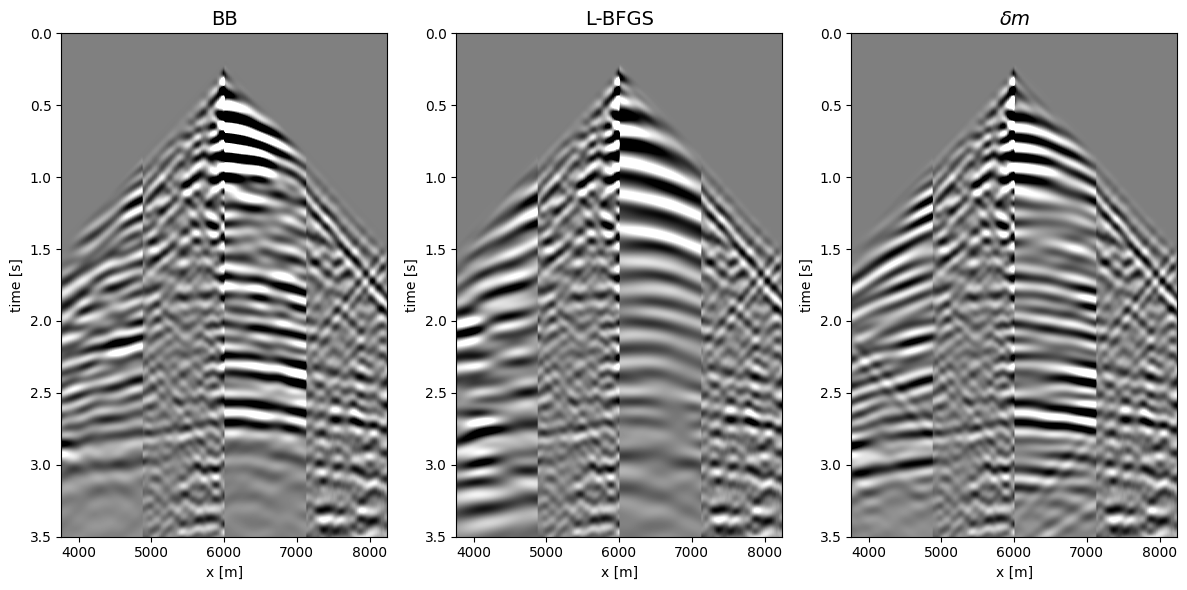

In [57]:
data_obs = observed_data[90][90:].T / 5
data1 = np.concatenate([-data_bb[90][:45].T, observed_data[90][45:90].T / 5, -data_bb[90][90:135].T , observed_data[90][135:].T / 5], axis=1)[:-499]
data2 = np.concatenate([-data_lbfgs[90][:45].T, observed_data[90][45:90].T / 5, -data_lbfgs[90][90:135].T , observed_data[90][135:].T / 5], axis=1)[:-499]
data3 = np.concatenate([-data_dm[90][:45].T, observed_data[90][45:90].T / 5, -data_dm[90][90:135].T , observed_data[90][135:].T / 5], axis=1)[:-499]
a = 'auto'
clip = 0.000002
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(data1, cmap='gray', vmin=-clip, vmax=clip, aspect=a, extent=(r[0,0],r[0,-1], 3.5, t[0]))
axs[0].set_title('BB', fontsize=14)
axs[0].set_xlabel(r'x [m]')
axs[0].set_ylabel(r'time [s]')
axs[0].set_ylim(3.5, 0)
axs[1].imshow(data2, cmap='gray', vmin=-clip, vmax=clip, aspect=a, extent=(r[0,0],r[0,-1], 3.5, t[0]))
axs[1].set_title('L-BFGS', fontsize=14)
axs[1].set_xlabel(r'x [m]')
axs[1].set_ylabel(r'time [s]')
axs[1].set_ylim(3.5, 0)
axs[2].imshow(data3, cmap='gray', vmin=-clip, vmax=clip, aspect=a, extent=(r[0,0],r[0,-1], 3.5, t[0]))
axs[2].set_title(r'$\delta m$', fontsize=14)
axs[2].set_xlabel(r'x [m]')
axs[2].set_ylabel(r'time [s]')
axs[2].set_ylim(3.5, 0)
plt.tight_layout()
plt.savefig(f'{folder_name}/data_fit.png', bbox_inches='tight', dpi=300)